# Import NetCDF files from CMEMS



Following the steps at the CMEMS web portal provides also a script to download the data.
The following command download CMEMS data using the motu-client. The CMEMS portal give a script like the following matching you search criteria:

```bash
python -m  motu-client --user "abarth" --pwd  "your*password" --motu http://nrt.cmems-du.eu/motu-web/Motu \
  --service-id MEDSEA_ANALYSIS_FORECAST_PHY_006_013-TDS --product-id sv04-med-ingv-tem-an-fc-d \
  --longitude-min -17.29166603088379 --longitude-max 36.29166793823242 \
  --latitude-min 30.1875 --latitude-max 45.97916793823242 \
  --date-min "2019-04-24 00:00:00" --date-max "2019-04-24 00:00:00" \
  --depth-min 1.0181 --depth-max 104.94500000000001 \
  --variable thetao --out-dir /tmp --out-name OUTPUT_FILENAME.nc
```


Import the necessary modules for linear algebra (the transpose operator), plotting via matplotlib and reading NetCDF Files 


In [8]:
using LinearAlgebra
using PyCall
using PyCall: PyObject
using PyPlot
using NCDatasets
using Statistics
using Dates

Some helper functions to make plotting data with missing values easier

In [9]:
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
  numpy_ma = pyimport("numpy").ma
  pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

PyObject(a::Adjoint{Array}) = PyObject(copy(a))

PyObject

# Load model data
Name of the downloaded NetCDF file

In [10]:
filename = "Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc"

"Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc"

List the metadata of the NetCDF file

In [11]:
ds = Dataset(filename)

Dataset: Data/sv04-med-ingv-tem-an-fc-d_1555334258448.nc
Group: /

Dimensions
   time = 1
   depth = 25
   lat = 380
   lon = 1287

Variables
  depth   (25)
    Datatype:    Float32
    Dimensions:  depth
    Attributes:
     units                = m
     nav_model            = Grid T
     positive             = down
     standard_name        = depth
     long_name            = depth
     axis                 = Z
     valid_min            = 1.0182366
     valid_max            = 104.94398
     _ChunkSizes          = 141
     _CoordinateAxisType  = Height
     _CoordinateZisPositive = down

  thetao   (1287 × 380 × 25 × 1)
    Datatype:    Float32
    Dimensions:  lon × lat × depth × time
    Attributes:
     _FillValue           = 1.0e20
     missing_value        = 1.0e20
     units                = degC
     coordinates          = time depth lat lon
     standard_name        = sea_water_potential_temperature
     long_name            = temperature
     _ChunkSizes          = Int32[1, 2

The time instance in the NetCDF file

In [12]:
ds["time"][:]

1-element Array{Union{Missing, DateTime},1}:
 2019-04-24T00:00:00

The depth (in m) for the first level:

In [13]:
ds["depth"][1]

1.0182366f0

Load the first layer and the first time instance:

In [14]:
SST = ds["thetao"][:,:,1,1];

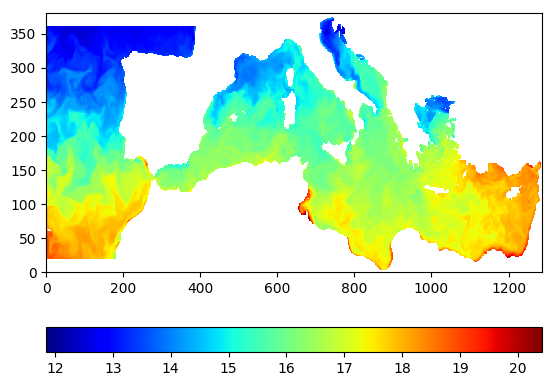

In [15]:
pcolor(SST', cmap="jet"); colorbar(orientation="horizontal");

A nicer plot with longitude and latitude as axes and the correct aspect ratio:

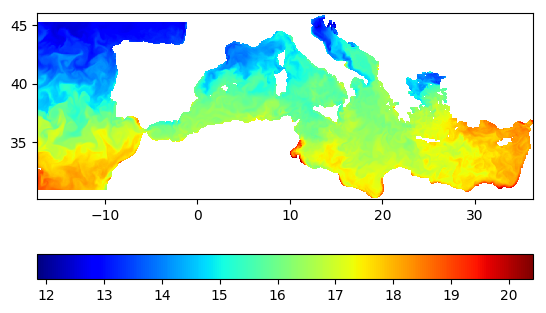

In [16]:
lon = ds["lon"][:];
lat = ds["lat"][:];
pcolor(lon,lat,SST', cmap="jet"); colorbar(orientation="horizontal");
gca().set_aspect(1/cos(pi*mean(lat) / 180))

List a depth levels in the NetCDF file

In [10]:
depth = ds["depth"][:]

25-element Array{Union{Missing, Float32},1}:
   1.0182366f0
   3.1657474f0
   5.4649634f0
   7.9203773f0
  10.536604f0 
  13.318384f0 
  16.270586f0 
  19.39821f0  
  22.706392f0 
  26.2004f0   
  29.885643f0 
  33.767673f0 
  37.852192f0 
  42.14504f0  
  46.65221f0  
  51.37986f0  
  56.334286f0 
  61.521957f0 
  66.94949f0  
  72.62369f0  
  78.5515f0   
  84.74004f0  
  91.19663f0  
  97.92873f0  
 104.94398f0  

Plot a vertical section at a constant latitude:

In [11]:
j = 200;
T = ds["thetao"][:,j,:,1];
lat[j]

38.479168f0

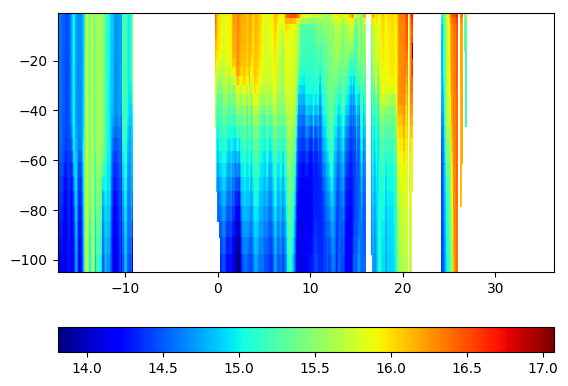

In [20]:
pcolor(lon,-depth,T'; cmap="jet"); colorbar(orientation="horizontal");

# In situ observations

The module PhysOcean can be installed with
```julia
using Pkg
Pkg.add("PhysOcean")
```

In [13]:
using PhysOcean

In [14]:
# username = "Joe"
# password = "p*ssw0rd"

username, password = split(read(expanduser("~/.cmems-credentials"),String),":", limit = 2);

Download temperature data within the specificed time range for any location

In [ ]:
lonr = [-Inf, Inf]
latr = [-Inf, Inf]
timerange = [DateTime(2018,1,1),DateTime(2018,1,10)]
param = "TEMP"
basedir = "InSitu-Data"
files = CMEMS.download(lonr,latr,timerange,param,username,password,basedir; 
    indexURLs = ["ftp://my.cmems-du.eu/Core/INSITU_NWS_TS_REP_OBSERVATIONS_013_043/index_history.txt"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1926k  100 1926k    0     0   247k      0  0:00:07  0:00:07 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3297k  100 3297k    0     0   272k      0  0:00:12  0:00:12 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2171k  100 2171k    0     0   252k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1321k  100 1321k    0     0   213k      0  0:00:06  0:00:06 --:--:--  308k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  691k  100  691k    0     0   168k      0  0:00:04  0:00:04 --:--:--  168k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2626k  100 2626k    0     0   270k      0  0:00:09  0:00:09 --:--:--  346k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2408k  100 2408k    0     0   266k      0  0:00:09  0:00:09 --:--:--  344k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 82 1664k   82 1373k    0     0   214k      0  0:00:07  0:00:06  0:00:01  278k

100 1664k  100 1664k    0     0   227k      0  0:00:07  0:00:07 --:--:--  334k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  989k  100  989k    0     0   190k      0  0:00:05  0:00:05 --:--:--  261k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1205k  100 1205k    0     0   209k      0  0:00:05  0:00:05 --:--:--  299k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1484k  100 1484k    0     0   230k      0  0:00:06  0:00:06 --:--:--  322k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1648k  100 1648k    0     0   234k      0  0:00:07  0:00:07 --:--:--  335k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  762k  100  762k    0     0   173k      0  0:00:04  0:00:04 --:--:--  178k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1611k  100 1611k    0     0   237k      0  0:00:06  0:00:06 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1839k  100 1839k    0     0   244k      0  0:00:07  0:00:07 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1830k  100 1830k    0     0   247k      0  0:00:07  0:00:07 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1770k  100 1770k    0     0   244k      0  0:00:07  0:00:07 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1223k  100 1223k    0     0   213k      0  0:00:05  0:00:05 --:--:--  276k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1207k  100 1207k    0     0   213k      0  0:00:05  0:00:05 --:--:--  291k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  987k  100  987k    0     0   197k      0  0:00:04  0:00:04 --:--:--  265k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  985k  100  985k    0     0   192k      0  0:00:05  0:00:05 --:--:--  259k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2249k  100 2249k    0     0   259k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1595k  100 1595k    0     0   228k      0  0:00:06  0:00:06 --:--:--  346k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2266k  100 2266k    0     0   258k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1030k  100 1030k    0     0   196k      0  0:00:05  0:00:05 --:--:--  263k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1233k  100 1233k    0     0   214k      0  0:00:05  0:00:05 --:--:--  275k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  977k  100  977k    0     0   180k      0  0:00:05  0:00:05 --:--:--  243k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1878k  100 1878k    0     0   239k      0  0:00:07  0:00:07 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2045k  100 2045k    0     0   250k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 96 1252k   96 1202k    0     0   215k      0  0:00:05  0:00:05 --:--:--  276k

100 1252k  100 1252k    0     0   218k      0  0:00:05  0:00:05 --:--:--  307k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1345k  100 1345k    0     0   221k      0  0:00:06  0:00:06 --:--:--  315k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1032k  100 1032k    0     0   201k      0  0:00:05  0:00:05 --:--:--  266k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 95 1891k   95 1805k    0     0   244k      0  0:00:07  0:00:07 --:--:--  348k

100 1891k  100 1891k    0     0   248k      0  0:00:07  0:00:07 --:--:--  347k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1183k  100 1183k    0     0   211k      0  0:00:05  0:00:05 --:--:--  276k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  292k  100  292k    0     0    98k      0  0:00:02  0:00:02 --:--:--   98k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  657k  100  657k    0     0   163k      0  0:00:04  0:00:04 --:--:--  163k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  708k  100  708k    0     0   164k      0  0:00:04  0:00:04 --:--:--  164k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1281k  100 1281k    0     0   219k      0  0:00:05  0:00:05 --:--:--  290k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  952k  100  952k    0     0   189k      0  0:00:05  0:00:05 --:--:--  254k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  654k  100  654k    0     0   163k      0  0:00:04  0:00:04 --:--:--  163k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 77  813k   77  634k    0     0   151k      0  0:00:05  0:00:04  0:00:01  151k

100  813k  100  813k    0     0   173k      0  0:00:04  0:00:04 --:--:--  182k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  864k  100  864k    0     0   185k      0  0:00:04  0:00:04 --:--:--  253k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  838k  100  838k    0     0   179k      0  0:00:04  0:00:04 --:--:--  248k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  773k  100  773k    0     0   177k      0  0:00:04  0:00:04 --:--:--  177k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  645k  100  645k    0     0   159k      0  0:00:04  0:00:04 --:--:--  159k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  409k  100  409k    0     0   123k      0  0:00:03  0:00:03 --:--:--  123k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  674k  100  674k    0     0   158k      0  0:00:04  0:00:04 --:--:--  158k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  587k  100  587k    0     0   151k      0  0:00:03  0:00:03 --:--:--  151k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 76  567k   76  431k    0     0   123k      0  0:00:04  0:00:03  0:00:01  123k

100  567k  100  567k    0     0   144k      0  0:00:03  0:00:03 --:--:--  144k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  805k  100  805k    0     0   157k      0  0:00:05  0:00:05 --:--:--  177k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  805k  100  805k    0     0   154k      0  0:00:05  0:00:05 --:--:--  216k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  551k  100  551k    0     0   127k      0  0:00:04  0:00:04 --:--:--  127k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  836k  100  836k    0     0   182k      0  0:00:04  0:00:04 --:--:--  251k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  834k  100  834k    0     0   181k      0  0:00:04  0:00:04 --:--:--  181k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 83  802k   83  669k    0     0   164k      0  0:00:04  0:00:04 --:--:--  164k

100  802k  100  802k    0     0   179k      0  0:00:04  0:00:04 --:--:--  184k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  828k  100  828k    0     0   175k      0  0:00:04  0:00:04 --:--:--  239k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  770k  100  770k    0     0   174k      0  0:00:04  0:00:04 --:--:--  174k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511k  100  511k    0     0   138k      0  0:00:03  0:00:03 --:--:--  138k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  640k  100  640k    0     0   157k      0  0:00:04  0:00:04 --:--:--  157k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  443k  100  443k    0     0   126k      0  0:00:03  0:00:03 --:--:--  126k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  825k  100  825k    0     0   178k      0  0:00:04  0:00:04 --:--:--  248k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1435k  100 1435k    0     0   226k      0  0:00:06  0:00:06 --:--:--  322k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2358k  100 2358k    0     0   263k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2359k  100 2359k    0     0   262k      0  0:00:08  0:00:08 --:--:--  347k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 70 1135k   70  802k    0     0   189k      0  0:00:05  0:00:04  0:00:01  189k

100 1135k  100 1135k    0     0   218k      0  0:00:05  0:00:05 --:--:--  229k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1355k  100 1355k    0     0   234k      0  0:00:05  0:00:05 --:--:--  294k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2096k  100 2096k    0     0   266k      0  0:00:07  0:00:07 --:--:--  348k--:--:--  0:00:01 --:--:--     0


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1640k  100 1640k    0     0   251k      0  0:00:06  0:00:06 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2346k  100 2346k    0     0   275k      0  0:00:08  0:00:08 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  713k  100  713k    0     0   184k      0  0:00:03  0:00:03 --:--:--  184k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  873k  100  873k    0     0   202k      0  0:00:04  0:00:04 --:--:--  206k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 20  270k   20 57600    0     0  21682      0 --:--:--  0:00:01 --:--:--     0    0  0:00:12  0:00:02  0:00:10 21678

100  270k  100  270k    0     0  82008      0  0:00:03  0:00:03 --:--:-- 82035
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2232k  100 2232k    0     0   250k      0  0:00:08  0:00:08 --:--:-1  348k

-  348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 90 1284k   90 1168k    0     0   223k      0  0:00:05  0:00:05 --:--:--  234k 0

100 1284k  100 1284k    0     0   231k      0  0:00:05  0:00:05 --:--:--  299k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1396k  100 1396k    0     0   240k      0  0:00:05  0:00:05 --:--:--  331k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 66  870k   66  576k    0     0   155k      0  0:00:05  0:00:03  0:00:02  155k

100  870k  100  870k    0     0   191k      0  0:00:04  0:00:04 --:--:--  191k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 90 1263k   90 1140k    0     0   224k      0  0:00:05  0:00:05 --:--:--  228k

100 1263k  100 1263k    0     0   231k      0  0:00:05  0:00:05 --:--:--  295k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  492k  100  492k    0     0   150k      0  0:00:03  0:00:03 --:--:--  150k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  815k  100  815k    0     0   197k      0  0:00:04  0:00:04 --:--:--  197k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  467k  100  467k    0     0   148k      0  0:00:03  0:00:03 --:--:--  148k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1156k  100 1156k    0     0   221k      0  0:00:05  0:00:05 --:--:--  286k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1206k  100 1206k    0     0   227k      0  0:00:05  0:00:05 --:--:--  292k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1209k  100 1209k    0     0   229k      0  0:00:05  0:00:05 --:--:--  292k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1075k  100 1075k    0     0   218k      0  0:00:04  0:00:04 --:--:--  286k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 97 1067k   97 1036k    0     0   217k      0  0:00:04  0:00:04 --:--:--  217k

100 1067k  100 1067k    0     0   220k      0  0:00:04  0:00:04 --:--:--  287k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 71  986k   71  701k    0     0   183k      0  0:00:05  0:00:03  0:00:02  182k

100  986k  100  986k    0     0   212k      0  0:00:04  0:00:04 --:--:--  212k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  781k  100  781k    0     0   191k      0  0:00:04  0:00:04 --:--:--  191k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1322k  100 1322k    0     0   236k      0  0:00:05  0:00:05 --:--:--  299k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  671k  100  671k    0     0   178k      0  0:00:03  0:00:03 --:--:--  177k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 85 1492k   85 1272k    0     0   234k      0  0:00:06  0:00:05  0:00:01  297k

100 1492k  100 1492k    0     0   246k      0  0:00:06  0:00:06 --:--:--  324k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  514k  100  514k    0     0   153k      0  0:00:03  0:00:03 --:--:--  153k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1176k  100 1176k    0     0   219k      0  0:00:05  0:00:05 --:--:--  286k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 64  832k   64  538k    0     0   157k      0  0:00:05  0:00:03  0:00:02  157k

100  832k  100  832k    0     0   194k      0  0:00:04  0:00:04 --:--:--  194k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  687k  100  687k    0     0   180k      0  0:00:03  0:00:03 --:--:--  180k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 78 1075k   78  845k    0     0   201k      0  0:00:05  0:00:04  0:00:01  201k

100 1075k  100 1075k    0     0   221k      0  0:00:04  0:00:04 --:--:--  231k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  820k  100  820k    0     0   171k      0  0:00:04  0:00:04 --:--:--  228k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  956k  100  956k    0     0   177k      0  0:00:05  0:00:05 --:--:--  240k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  983k  100  983k    0     0   211k      0  0:00:04  0:00:04 --:--:--  211k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  390k  100  390k    0     0   134k      0  0:00:02  0:00:02 --:--:--  134k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  392k  100  392k    0     0   135k      0  0:00:02  0:00:02 --:--:--  135k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  626k  100  626k    0     0   174k      0  0:00:03  0:00:03 --:--:--  174k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 76  749k   76  572k    0     0   161k      0  0:00:04  0:00:03  0:00:01  161k

100  749k  100  749k    0     0   184k      0  0:00:04  0:00:04 --:--:--  184k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 96  883k   96  852k    0     0   192k      0  0:00:04  0:00:04 --:--:--  192k

100  883k  100  883k    0     0   195k      0  0:00:04  0:00:04 --:--:--  270k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 94 1841k   94 1733k    0     0   254k      0  0:00:07  0:00:06  0:00:01  346k  0  0:00:15  0:00:02  0:00:13  121k7  181k

100 1841k  100 1841k    0     0   258k      0  0:00:07  0:00:07 --:--:--  347k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 88 2668k   88 2370k    0     0   275k      0  0:00:09  0:00:08  0:00:01  348k

100 2668k  100 2668k    0     0   281k      0  0:00:09  0:00:09 --:--:--  348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2307k  100 2307k    0     0   273k      0  0:00:08  0:00:08 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 95 2477k   95 2354k    0     0   275k      0  0:00:09  0:00:08  0:00:01  348k

100 2477k  100 2477k    0     0   277k      0  0:00:08  0:00:08 --:--:--  348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1565k  100 1565k    0     0   244k      0  0:00:06  0:00:06 --:--:--  323k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1855k  100 1855k    0     0   258k      0  0:00:07  0:00:07 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1899k  100 1899k    0     0   259k      0  0:00:07  0:00:07 --:--:--  348k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0  48929      0  0:00:02  0:00:02 --:--:-- 48945


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0  65634      0  0:00:02  0:00:02 --:--:-- 65623


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 53944    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100 53944  100 53944    0     0  27290      0  0:00:01  0:00:01 --:--:-- 27285
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0  87675      0  0:00:02  0:00:02 --:--:-- 87681


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100 34732  100 34732    0     0  18200      0  0:00:01  0:00:01 --:--:-- 18193
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0  62029      0  0:00:02  0:00:02 --:--:-- 62055


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100  109k  100  109k    0     0  53603      0  0:00:02  0:00:02 --:--:-- 53581
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100 24664  100 24664    0     0  12840      0  0:00:01  0:00:01 --:--:-- 12839
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55164  100 55164    0     0  27986      0  0:00:01  0:00:01 --:--:-- 27987358


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 22  100k   22 23040    0     0  12383      0  0:00:08  0:00:01  0:00:07 12380

100  100k  100  100k    0     0  49387      0  0:00:02  0:00:02 --:--:-- 49405
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0  67336      0  0:00:02  0:00:02 --:--:-- 67352


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  142k  100  142k    0     0  66879      0  0:00:02  0:00:02 --:--:--     0

--:-- 66901
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  192k  100  192k    0     0  79698      0  0:00:02  0:00:02 --:--:-- 79697


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100 62540  100 62540    0     0  32066      0  0:00:01  0:00:01 --:--:-- 32055
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  118k  100  118k    0     0  47042      0  0:00:02  0:00:02 --:--:-- 47039


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37864  100 37864    0     0  13262      0  0:00:02  0:00:02 --:--:-- 13262


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100 36572  100 36572    0     0  13624      0  0:00:02  0:00:02 --:--:-- 13625
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0  86383      0  0:00:02  0:00:02 --:--:-- 86363


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239k  100  239k    0     0  97535      0  0:00:02  0:00:02 --:--:-- 97551


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  278k  100  278k    0     0   107k      0  0:00:02  0:00:02 --:--:--  107k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 97 11.5M   97 11.2M    0     0   325k      0  0:00:36  0:00:35  0:00:01  314k

100 11.5M  100 11.5M    0     0   330k      0  0:00:35  0:00:35 --:--:--  348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 99 46.5M   99 46.5M    0     0   343k      0  0:02:18  0:02:18 --:--:--  420k 348k

100 46.5M  100 46.5M    0     0   343k      0  0:02:18  0:02:18 --:--:--  348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.5M  100 60.5M    0     0   345k      0  0:02:59  0:02:59 --:--:--  354k0  0:03:11  0:00:24  0:02:47  348k1  348k0:32  292k348kk:08  341k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  1 54.5M    1  624k    0     0   154k      0  0:06:02  0:00:04  0:05:58  154k

### Loading a single drifter file

In [18]:

fname = "InSitu-Data/my.cmems-du.eu/Core/INSITU_NWS_TS_REP_OBSERVATIONS_013_043/history/drifter/GL_TS_DB_4700539.nc"
ds = Dataset(fname);
lon = ds["LONGITUDE"][:];
lat = ds["LATITUDE"][:];
T = ds["TEMP"][:];
obstime = ds["TIME"][:];
close(ds)
sel = .!ismissing.(T[1,:]);
@show sum(sel)
@show extrema(obstime[sel])

sum(sel) = 20647
extrema(obstime[sel]) = (2016-03-08T20:00:00, 2018-12-31T23:00:00)


(2016-03-08T20:00:00, 2018-12-31T23:00:00)

### Plotting a drifter trajectory

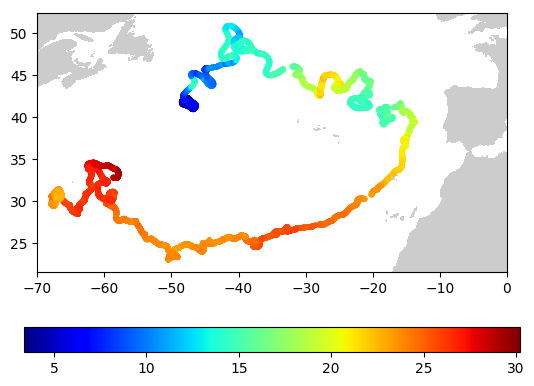

In [19]:
using OceanPlot
scatter(lon[sel],lat[sel],10,T[sel],cmap="jet")
colorbar(orientation = "horizontal")
xlim(-70,0)
OceanPlot.plotmap()
gca().set_aspect(1/cos(pi*mean(ylim()) / 180))